# Обучение без учителя
- В задачах машинного обучения без учителя нет целевой переменной (правильных ответов), есть только признаковое описание объектов. Необходимо выявить некоторые скрытые закономерности данных, понять, как объекты устроены, есть ли в данных какая-то структура.
- **Кластеризация**: k-means, DBSCAN, ...
- **Визуализация**: PCA, t-SNE, ...
- Задача кластеризации состоит в том, чтобы разбить объекты, которые даны в выборке, на несколько кластеров, так чтобы объекты в одном кластере были похожи друг на друга, а объекты в разных кластерах были не похожи друг на друга.

# 1. k-means
Кластеры представляют собой центроиды, то есть каждый кластер задаётся координатами центра, а точки относятся к тому кластеру, чей центр к ним ближе. 
<img src='images/kmeans.png'>

**Минимизируем полную сумму квадратов расстояний от каждой точки до среднего значения назначенного ей кластера**

Итерационный алгоритм:
1. берём k случайных центров (*k средних*)
2. присоединяем все объекты к ближайшему к ним кластеру
3. пересчитываем координаты кластеров, чтобы они оказались в центре масс точек, которые относятся к ним. То есть для каждой центроиды берём все точки, которые к ней относятся, считаем среднее.
4. снова ищем для каждой точки ближайший центроид
- Если ни у одной точки её назначение не изменилось, то останавливаемся и сохраняем кластеры.
### Достоинства:
+ Очень простой алгоритм
+ Работает даже на больших данных
### Недостатки:
- Надо задавать число k руками
- Не всегда находит кластеры правильно (ищет только кластеры выпуклой формы)
- сильно зависит от начальной инициализации центров кластеров (разный результат от запуска к запуску)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(42)

In [3]:
X1 = np.random.normal(loc=[0,-10], size=(100,2))
X2 = np.random.normal(loc=[-10, 0], size=(100,2))
X3 = np.random.normal(loc=[0, 0], size=(100,2))
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)

In [4]:
k_means = KMeans(n_clusters=3)

In [5]:
clusters = k_means.fit_predict(X)

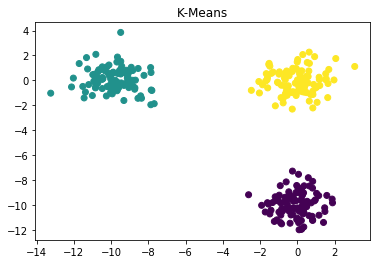

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.title('K-Means')
plt.show()

Попробуем разное количество кластеров:

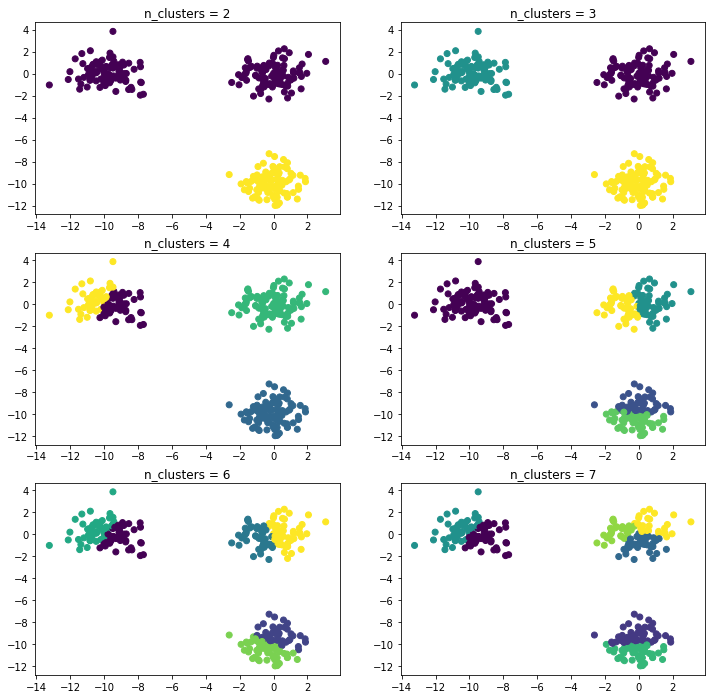

In [7]:
plt.figure(figsize=(12, 12))
for n_c in range(2, 8):
    k_means = KMeans(n_clusters=n_c)
    clusters = k_means.fit_predict(X)
    plt.subplot(3, 2, n_c-1)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title('n_clusters = {}'.format(n_c))
plt.show()

### Оценка качества разбиения, выбор числа кластеров, SSE, elbow method
Дана матрица данных $X$ и дано число $k$ предполагаемых кластеров. Цель кластеризации представить данные в виде групп кластеров $C=\{C_1, C_2, \ldots, C_k\}$. Каждый кластер имеет свой центр:

\begin{equation}
\mu_i = \frac{1}{n_i} \sum \limits_{x_j \in C_i} x_j
\end{equation}

где $n_i = |C_i|$ - это количество точек в кластере $C_i$.

Таким образом, мы имеем некоторые кластеры $C=\{C_1, C_2, \ldots, C_k\}$ и необходимо оценить качество разбиения. Для этого будем вычислять сумму квадратических ошибок (**SSE, sum of squared error**):

\begin{equation}
SSE(C) = \sum \limits_{i=1}^{k} \sum \limits_{x_j \in C_i} ||x_j - \mu_i||^2
\end{equation}

Сумма квадратов расстояний между центроидом и каждым объектом кластера. 
Цель найти
\begin{equation}
C^* = arg\min\limits_C \{SSE(C)\}
\end{equation}
<img src='images/sse.png'>

Выбирается число кластеров в месте "преломления" графика


# 2. DBSCAN
Идея: хотим найти скопления точек, не зная заранее количество кластеров

Нужно задать два параметра:
- размер окрестности точки $\epsilon$
- minPts - минимальное количество точек в $\epsilon$ - окрестности

Тогда все точки можно разделить на три типа:
- Core (ядровые) точки - у которых в $\epsilon$ - окрестности от minPts соседей
- Border (граничные) точки - не Core точки, но достижимы из Core точек
- Noise (шумовые) точки - все остальные, меньше minPts соседей в $\epsilon$ - окрестности

<img src = 'images/DBSCAN.png'>

- minPts = 4
- вокруг каждой точки есть своя $\epsilon$ - окрестность
- точка А и все красные точки - core (ядровые), так как $\epsilon$ окрестность вокруг них содержит по 4 и более точек (включая себя).
- точки B и С -border points, они не core points (ядровые), но они достижимы из A через другие ядровые точки, поэтому они тоже принадлежат кластеру
- точка N - шум

### Алгоритм:
1. берём следующую точку, ищем соседей в $\epsilon$ окрестности
2. если их как минимум minPts, то начинаем поиск связной компоненты из этой core-точки (обход в ширину)
3. иначе помечаем точку как noise, она может быть позднее к какой-то Core-точке как Border-точка

<img src='images/DBSCAN1.png'>
Начинаем с точки P2. minPts=2. Нашли ближайших соседей P2 - P1 и P3, они внутри окрестности. Всего в окрестности находится 3 точки, это больше minPts, поэтому P2 - это core-точка. Из неё нужно запустить поиск связной компоненты. Для этого проверим соседей P1 и P3. 



<img src='images/DBSCAN2.png'>
В окрестности P1 находится две точки, она тоже core. Но никаких новых точек из неё не было найдено. 
<img src='images/DBSCAN3.png'>
Проверим теперь P3 точку. У неё в окрестности три точки (core), причем P4 - новая точка. То есть из начальной точки P2 можно достичь точки P4 по цепочке из core точек. 
<img src='images/DBSCAN4.png'>
Core. Достигаем новой точки P5. Проверяем P5, больше не находим непосещенных точек. Это значит, что кластер найден. 
<img src='images/DBSCAN5.png'>
<img src='images/DBSCAN6.png'>
<img src='images/DBSCAN7.png'>
Берём следующую непомеченную точку P6. Ищем соседей в окрестности. Их нет. Noise.
<img src='images/DBSCAN8.png'>

### Достоинства:
+ Не нужно задавать количество кластеров
+ Кластеры могут быть любой формы
+ Может работать с шумными данными
### Недостатки:
- Долго работает на больших данных
- Чувствителен к выбору гиперпараметров (лучше использовать иерархический HDBSCAN)

In [8]:
from sklearn.cluster import DBSCAN

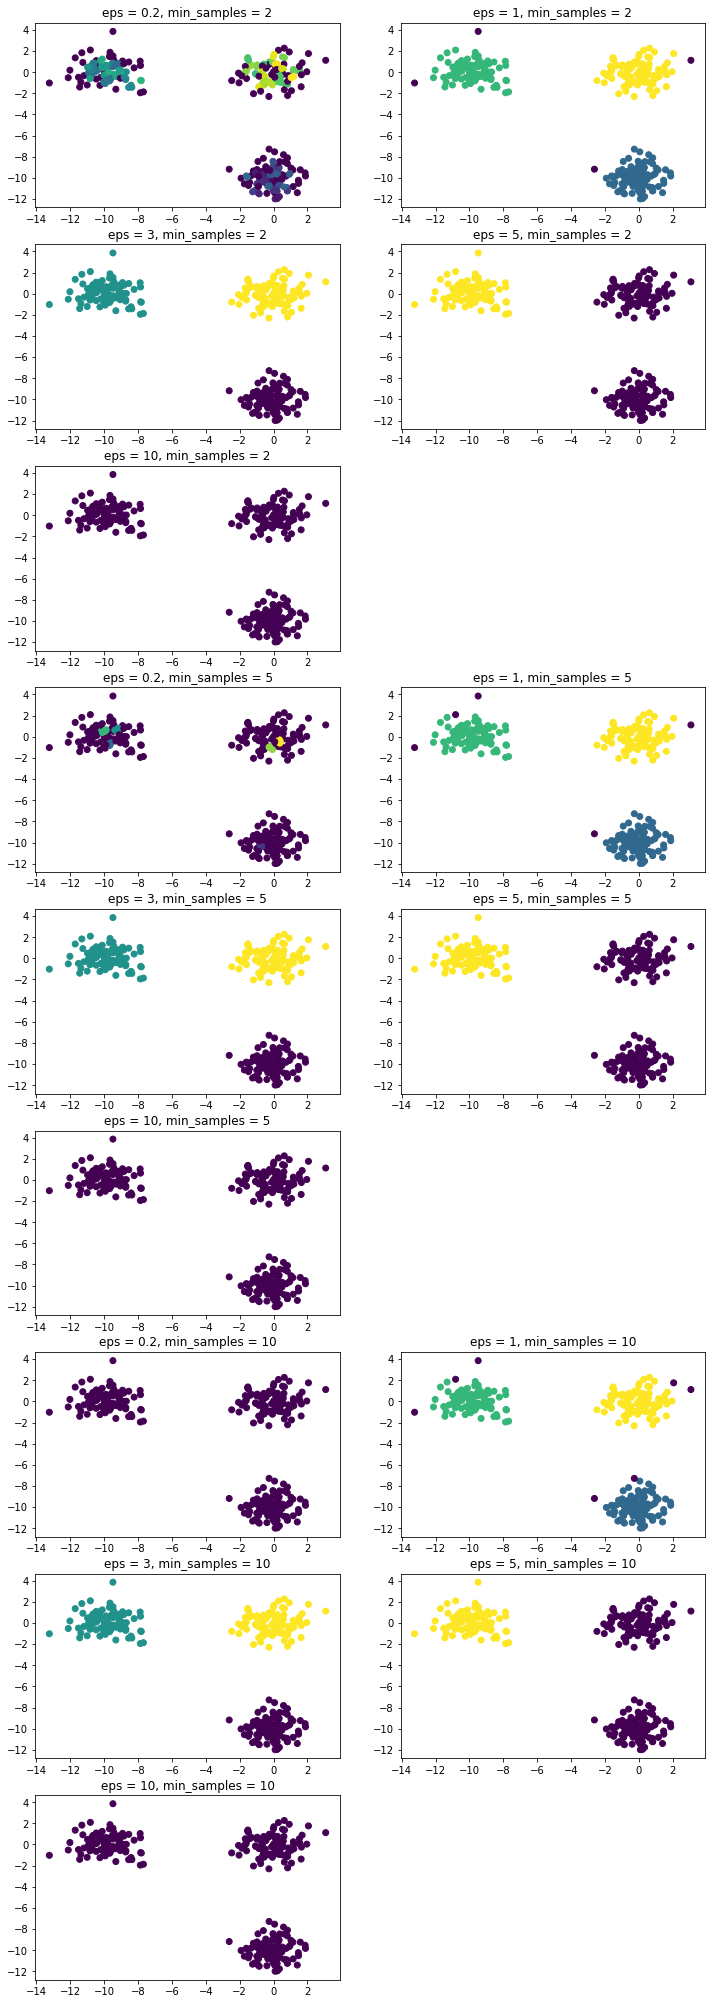

In [9]:
from sklearn.cluster import DBSCAN
plt.figure(figsize=(12, 36))
i = 1
for sample in [2, 5, 10]:
    for e in [0.2, 1, 3, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=sample)
        clusters = dbscan.fit_predict(X)
        plt.subplot(9, 2, i)
        plt.scatter(X[:, 0], X[:, 1], c=clusters)
        plt.title('eps = {}, min_samples = {}'.format(e, sample))
        i += 1
    i += 1
plt.show()

- Если маленький радиус е и мало объектов, то DBSCAN находит много выбросов
- Если увеличить радиус и не менять количество объектов, то часть из них остается выбросами
- Если еще увеличить радиус, то выбросы пропадают
- Если еще сильнее увеличить радиус, то выделяется только один кластер и т.д.

### Kmeans и DBSCAN на более сложных данных

In [10]:
n_samples = 1500
X = datasets.make_circles(n_samples=n_samples, 
                          factor = 0.5, 
                          noise = 0.05)
X = X[0]
X.shape

(1500, 2)

In [11]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(X)

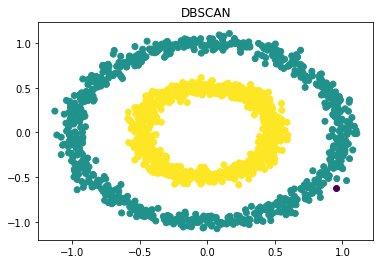

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.title('DBSCAN');


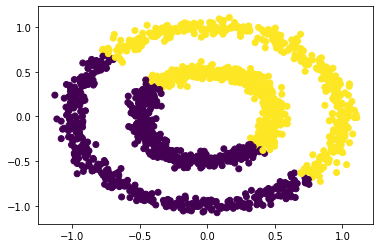

In [13]:
k_means = KMeans(n_clusters=2)
clusters = k_means.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = clusters);

# Пример

In [14]:
from sklearn.datasets import load_digits

In [15]:
digits = load_digits()
X, y = digits['data'], digits['target']

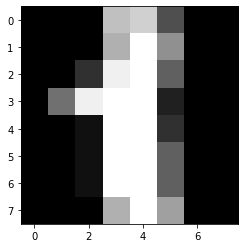

In [16]:
plt.imshow(X[1].reshape(8, 8), cmap='gray')

In [17]:
km = KMeans(n_clusters=10)

In [18]:
clusters = km.fit_predict(X)

In [19]:
pred = np.zeros(X.shape[0])

In [20]:
for i in range(10):
    bc = np.bincount(y[clusters == i])
    pred[clusters == i] = bc.argmax() # преобладающая метка в кластере

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
accuracy_score(y, pred)

0.7924318308291597

Ошибки кластеризации для нуля:

In [23]:
incorrect_indices = np.where(np.logical_and(pred == 0, y!=0))[0]

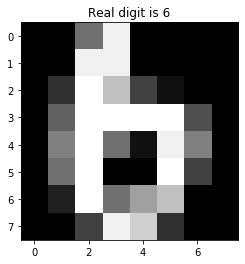

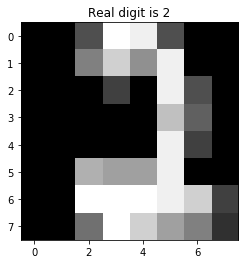

In [24]:
for i in range(2):
    plt.imshow(X[incorrect_indices[i]].reshape(8, 8), cmap='gray')
    plt.title('Real digit is {}'.format(y[incorrect_indices[i]]))
    plt.show()

In [25]:
correct_indices = np.where(np.logical_and(pred == 0, y == 0))[0]

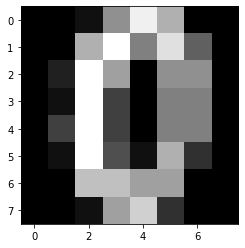

In [26]:
for i in range(2):
    plt.imshow(X[correct_indices[i]].reshape(8, 8), cmap='gray')

## Другие алгоритмы кластеризации

<img src='images/cluster_comparison.png'>

# Домашнее задание 2
## Задание 1
1. Реализовать kmeans
2. Визуализировать сходимость центров кластеров
3. Оценить $SSE$ для значений $k = 1, \ldots, 10$ и построить график зависимости $SSE$ от количества кластеров.





### Алгоритм к-средних
На вход алгоритм получает матрицу данных $D$, количество кластеров $k$, и критерий остановки $\epsilon$:
1. t = 0
2. случайным образом инициализируем $k$ центров кластеров: $\mu_1^t, \mu_2^t, \ldots, \mu_k^t \in R^d$;
3. повторять
    4. $t = t + 1$;
    5. $C_j = 0$ для всех $j = 1, \ldots, k$
    6. для каждого $x_j \in D$
        7. $j^* = arg\min\limits_C \{||X_j - \mu_i^{t-1}||^2\}$ \\\ присваиваем $x_j$ к ближайшему центру
        8. $C_{j^*} = C_{j^*} \cup {x_j}$
    9. для каждого i=1 до k
        10. $\mu_i = \frac{1}{|C_i|} \sum_{x_j \in C_i} x_j$
11. пока $\sum_{i=1}^k ||\mu_i^{t} - \mu_i^{t-1}||^2 \leq \epsilon$

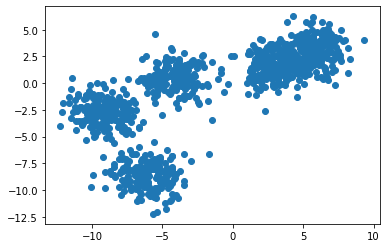

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples = 1000, n_features=2, centers=5, cluster_std = 1.2, random_state=17)
plt.scatter(X[:,0], X[:,1])

## Задание 2
1. Исследуйте данные с помощью pandas. Посмотрите на признаки и их распределения. (Например, постройте график распределения автомобилей по годам, типу топлива и т.д.)
2. Кластеризуйте данные с помощью KMeans из sklearn.clustering. Найдите оптимальное число кластеров
3. Произведите анализ получившихся кластеров:

Пример: первый кластер содержит полноприводные автомобили немецкого производства с АКПП, небольшим пробегом и высокой стоимостью, второй - японцы с правым рулём ...

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/2.csv', encoding='cp1251')
df = df.drop(columns=['Модель', 'Цвет'])
df.head()

,Марка,Год,Состояние,Пробег,Объем,Топливо,Мощность,Кузов,Привод,КПП,Руль,Хозяев в ПТС,Цена
0,Volkswagen,2013.0,БУ,42000.0,1200.0,бензин,105.0,хэтчбек,передний,автомат,левый,1 владелец,689196.0
1,Skoda,2012.0,БУ,62000.0,1800.0,бензин,152.0,кроссовер,полный,механика,левый,1 владелец,639196.0
2,Renault,2015.0,БУ,4700.0,1600.0,бензин,106.0,хэтчбек,передний,механика,левый,1 владелец,629196.0
3,Nissan,2012.0,БУ,70000.0,1600.0,бензин,110.0,хэтчбек,передний,автомат,левый,1 владелец,479196.0
4,УАЗ,2014.0,БУ,50000.0,2700.0,бензин,128.0,внедорожник,полный,механика,левый,1 владелец,599196.0
